# Reviewing Learning Curve

### Learning objectives

1. Build and train a Keras Sequential model
2. Specify various learning rates to a model
3. Visualize the loss curves


## Introduction 


In this notebook, you will observe learning curve change. You will use the Keras Sequential Model to build an ML model to predict housing prices.

A learning curve is a plot of model learning performance over experience or time.

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves. Reviewing learning curves of models during training can be used to diagnose problems with learning, such as an underfit or overfit model, as well as whether the training and validation datasets are suitably representative.

Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. [How to use Learning Curves to Diagnose Machine Learning Model Performance](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/#:~:text=A%20learning%20curve%20is%20a,from%20a%20training%20dataset%20incrementally.&text=Learning%20curves%20are%20plots%20that,time%20in%20terms%20of%20experience).

Each learning objective will correspond to a __#TODO__  in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/art_and_science_of_ml/solutions/learning_rate.ipynb)


Start by importing the necessary libraries for this lab.

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
# Install Sklearn
!python3 -m pip install --user sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=1c8e03b7447efde6601a20416ba8893c01cfd381b682d45447ff3954a7cfb87f
  Stored in directory: /home/jupyter/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [4]:
import os
import tensorflow.keras

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import layers
#from keras.optimizers import Adam
#from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from keras.utils import plot_model

print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.5.0


Many of the Google Machine Learning Courses Programming Exercises use the  [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description
), which contains data drawn from the 1990 U.S. Census.  Our lab dataset has been pre-processed so that there are no missing values.

First, let's download the raw .csv data by copying the data from a cloud storage bucket.


In [5]:
if not os.path.isdir("../data"):
    os.makedirs("../data")

In [6]:
!gsutil cp gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv ../data

Copying gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      


Now, let's read in the dataset just copied from the cloud storage bucket and create a Pandas dataframe.

In [7]:
housing_df = pd.read_csv('../data/housing_pre-proc.csv', error_bad_lines=False)
housing_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can use .describe() to see some summary statistics for the numeric fields in our dataframe. Note, for example, the count row and corresponding columns. The count shows 20433.000000 for all feature columns. Thus, there are no missing values.

####  Split the dataset for ML

The dataset we loaded was a single CSV file. We will split this into train, validation, and test sets.


In [8]:
train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

train.to_csv('../data/housing-train.csv', encoding='utf-8', index=False)
val.to_csv('../data/housing-val.csv', encoding='utf-8', index=False)
test.to_csv('../data/housing-test.csv', encoding='utf-8', index=False)

13076 train examples
3270 validation examples
4087 test examples


In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('median_house_value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Next we initialize the training and validation datasets.
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

# Input Pipeline
numeric_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

# Next, we scale the numerical feature columns that we assigned to the variable "numeric cols".
# Scalar def get_scal(feature):
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)
    
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))


### Using the Keras Sequential Model

Next, we will run this cell to compile and fit the Keras Sequential model.

**Lab Task #1:** Building the model

## Model 1 - hard coding the learning rate to .5

**Lab Task #2:** Specify various learning rates to model

In [11]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype = 'float64')

model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(12, input_dim = 8, activation = 'relu'),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(1, activation = 'linear', name = 'median_house_value')
])

# Model compile
opt = keras.optimizers.Adam(learning_rate = 0.5)
model.compile(optimizer = opt,
             loss = 'mse',
             metrics = ['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
408/409 [============================>.] - ETA: 0s - loss: 16026277888.0000 - mse: 16026277888.0000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

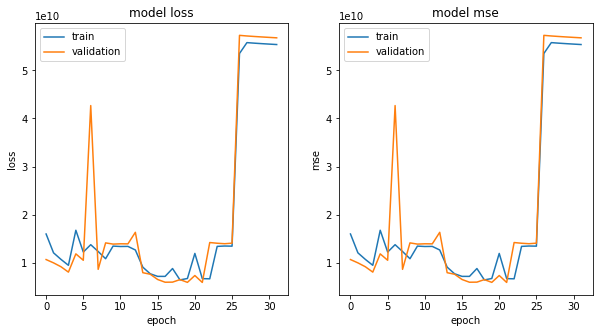

In [12]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left'); 
plot_curves(history, ['loss', 'mse'])

## Model 2 - hard coding the learning rate to .1

In [13]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.1),
             loss = 'mse',
             metrics = ['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
403/409 [============================>.] - ETA: 0s - loss: 16881413120.0000 - mse: 16881413120.0000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

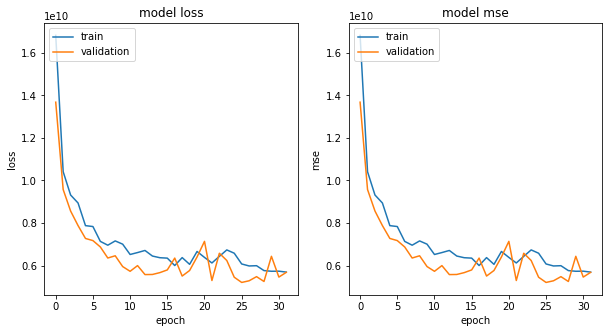

In [14]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  
plot_curves(history, ['loss', 'mse'])

## Model 3 - hard coding the learning rate to .01 

In [15]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01),
             loss = 'mse',
             metrics = ['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)  # Increase Epochs to 32

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
392/409 [===========================>..] - ETA: 0s - loss: 29027852288.0000 - mse: 29027852288.0000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

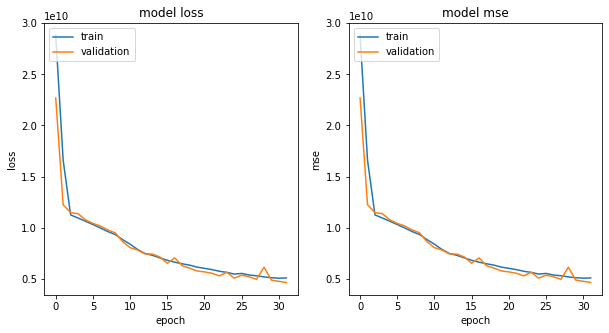

In [16]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  
plot_curves(history, ['loss', 'mse'])

## Model 4 - hard coding the learning rate to .001 

In [17]:
# Model create

feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
             loss = 'mse',
             metrics = ['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)  # Increase Epochs to 32

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
403/409 [============================>.] - ETA: 0s - loss: 52721741824.0000 - mse: 52721741824.0000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

**Lab Task #3:** Visualizing the loss curves

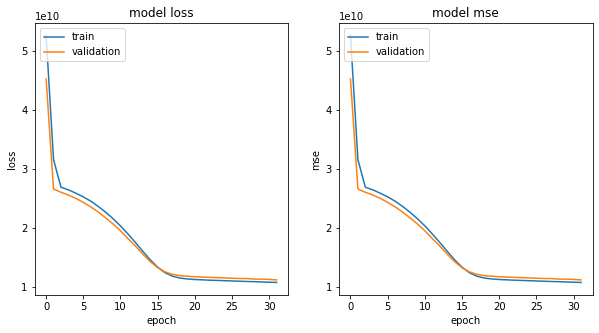

In [19]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
# Using the `figure()` method we can create a new figure or activate an existing figure.
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
# Using the `add_subplot()` method we can add a subplot to the current figure.
        ax = fig.add_subplot(nrows, ncols, idx+1)
# The `plot()` is a versatile function and will take an arbitrary number of arguments. 
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
# Using the `legend()` method we can place a legend on the axes.
        plt.legend(['train', 'validation'], loc='upper left'); 

plot_curves(history, ['loss', 'mse'])

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.